In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from math import sqrt

In [23]:
train = pd.read_csv("../data/schemas/warm_up/TrainSet.csv", sep=",")
validation = pd.read_csv("../data/schemas/warm_up/ValidationSet.csv", sep=",")
test = pd.read_csv("../data/schemas/warm_up/TestSet.csv", sep=",")

In [24]:
# Global variables

NUM_OF_TIMESTEPS_INPUT = 48
NUM_OF_TIMESTEPS_OUTPUT = 24

THRESHOLD = 0.4   # For feature selection

In [25]:
columns_to_predict = ["kg_CO2/kWh", "Avg solar generation"]

independent_variables = []

for column in train:
    if abs(train[column].corr(train[columns_to_predict[0]])) > THRESHOLD: #or abs(train[column].corr(train[columns_to_predict[1]])) > THRESHOLD:
        independent_variables.append(column)

independent_variables = [var for var in independent_variables if var not in columns_to_predict]
    
if "Index" in independent_variables:
    independent_variables.remove("Index")
if "Solar Generation (W/kW)_1" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_1")
if "Solar Generation (W/kW)_2" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_2")
if "Solar Generation (W/kW)_3" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_3")
    
print(independent_variables)

['Hour_1', 'Hour_2', 'Hour_3', 'Occupant Count (people)_3', '12h Outdoor Drybulb Temperature (C)', '24h Outdoor Drybulb Temperature (C)', '12h Outdoor Relative Humidity (%)', '6h Direct Solar Radiation (W/m2)', '12h Direct Solar Radiation (W/m2)']


Prepare the data

In [26]:
# Split the X and Y for all sets

# Train set
X_train_default = train[independent_variables]
Y_train_default = train[columns_to_predict]

# Validation set, also include the data from train that was used only as output to get more datapoints
X_val_default = pd.concat([X_train_default.tail(NUM_OF_TIMESTEPS_OUTPUT), validation[independent_variables]], ignore_index=True)
Y_val_default = pd.concat([Y_train_default.tail(NUM_OF_TIMESTEPS_OUTPUT), validation[columns_to_predict]], ignore_index=True)

# Test set, also include the data from train that was used only as output to get more datapoints
X_test_default = pd.concat([X_val_default.tail(NUM_OF_TIMESTEPS_OUTPUT), test[independent_variables]], ignore_index=True)
Y_test_default = pd.concat([Y_val_default.tail(NUM_OF_TIMESTEPS_OUTPUT), test[columns_to_predict]], ignore_index=True)

NUM_OF_ROWS_TRAIN, NUM_OF_FEATURES = X_train_default.shape

print(X_train_default.shape)
print(X_val_default.shape)
print(X_test_default.shape)

(576, 9)
(96, 9)
(96, 9)


In [27]:
# Function to prepare the data into batches that will be passed into the model

def create_sequences(input_data, output_data, timesteps_input, timesteps_output):
    sequences, targets = [], []
    for i in range(len(input_data) - timesteps_input - timesteps_output + 1):
        seq = input_data[i:i + timesteps_input]
        target = output_data[i + timesteps_input: i + timesteps_input + timesteps_output]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [28]:
X_train, Y_train = create_sequences(X_train_default, Y_train_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
X_val, Y_val = create_sequences(X_val_default, Y_val_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
X_test, Y_test = create_sequences(X_test_default, Y_test_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)

print(f"X_train = {X_train.shape}, Y_train = {Y_train.shape}\n"
      f"X_val = {X_val.shape}, Y_val = {Y_val.shape}\n"
      f"X_test = {X_test.shape}, Y_test = {Y_test.shape}")

X_train = (505, 48, 9), Y_train = (505, 24, 2)
X_val = (25, 48, 9), Y_val = (25, 24, 2)
X_test = (25, 48, 9), Y_test = (25, 24, 2)


In [29]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models
import time

tscv = TimeSeriesSplit(n_splits = 4, test_size=24) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 4) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Dense layers for variable 1
lstm1 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(input_layer)
lstm2 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(lstm1)
lstm3 = layers.LSTM(24, activation='leaky_relu', return_sequences=False)(lstm2)
output_variable1 = layers.Dense(24, name='output_variable1')(lstm3)

# Dense layers for variable 2
dense4 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(input_layer)
dense5 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(dense4)
dense6 = layers.LSTM(24, activation='leaky_relu', return_sequences=False)(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

model.compile(
    optimizer='adam',
    loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
) #types of optimizer, loss function to be adjusted
    
start = time.time()

for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]
    
    history = model.fit(X_train_current_split, y={"output_variable1": y_train_current_split[:, :, 0], 
                                                  "output_variable2": y_train_current_split[:, :, 1]},
              epochs=50, 
              validation_data=(
                  X_test_current_split,
                {
                    "output_variable1": y_test_current_split[:, :, 0],
                    "output_variable2": y_test_current_split[:, :, 1],
                },
              ),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    loss_1.append(model.history.history['output_variable1_loss'])
    val_loss_1.append(model.history.history['val_output_variable1_loss'])
    
    loss_2.append(model.history.history['output_variable2_loss'])
    val_loss_2.append(model.history.history['val_output_variable2_loss'])
    
end = time.time()

print(f"Training time = {end - start} seconds")

Epoch 1/50
13/13 [==============================] - 14s 173ms/step - loss: 0.4710 - output_variable1_loss: 0.3072 - output_variable2_loss: 0.1638 - val_loss: 0.6643 - val_output_variable1_loss: 0.5765 - val_output_variable2_loss: 0.0878
Epoch 2/50
13/13 [==============================] - 1s 52ms/step - loss: 0.3367 - output_variable1_loss: 0.2137 - output_variable2_loss: 0.1230 - val_loss: 0.4753 - val_output_variable1_loss: 0.4021 - val_output_variable2_loss: 0.0733
Epoch 3/50
13/13 [==============================] - 1s 52ms/step - loss: 0.2475 - output_variable1_loss: 0.1425 - output_variable2_loss: 0.1051 - val_loss: 0.3743 - val_output_variable1_loss: 0.3034 - val_output_variable2_loss: 0.0708
Epoch 4/50
13/13 [==============================] - 1s 57ms/step - loss: 0.1780 - output_variable1_loss: 0.0870 - output_variable2_loss: 0.0910 - val_loss: 0.1747 - val_output_variable1_loss: 0.1017 - val_output_variable2_loss: 0.0730
Epoch 5/50
13/13 [==============================] - 1s 54m

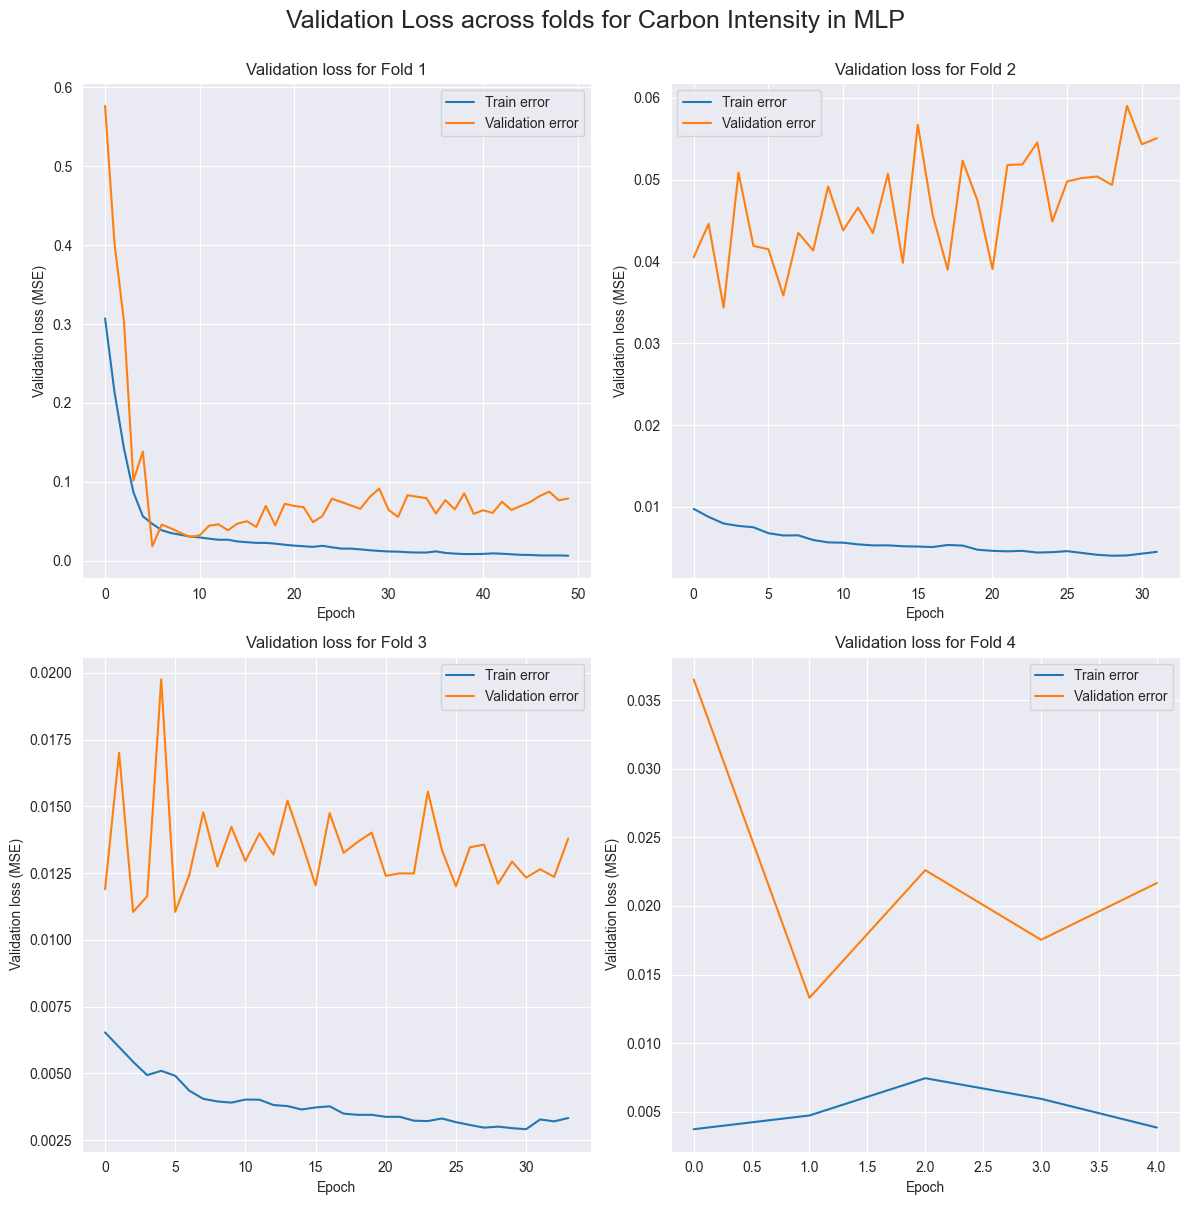

In [30]:
plt.figure(figsize=(12, 12))

for i, column in enumerate(loss_1):
    plt.subplot(2, 2, i+1)
    plt.plot(column, label="Train error")
    plt.plot(val_loss_1[i], label="Validation error")
    plt.xlabel('Epoch')
    plt.ylabel('Validation loss (MSE)')
    plt.legend()
    plt.title(f'Validation loss for Fold {i+1}')

plt.suptitle('Validation Loss across folds for Carbon Intensity in MLP', fontsize=18, y=1)
plt.tight_layout()
plt.show()

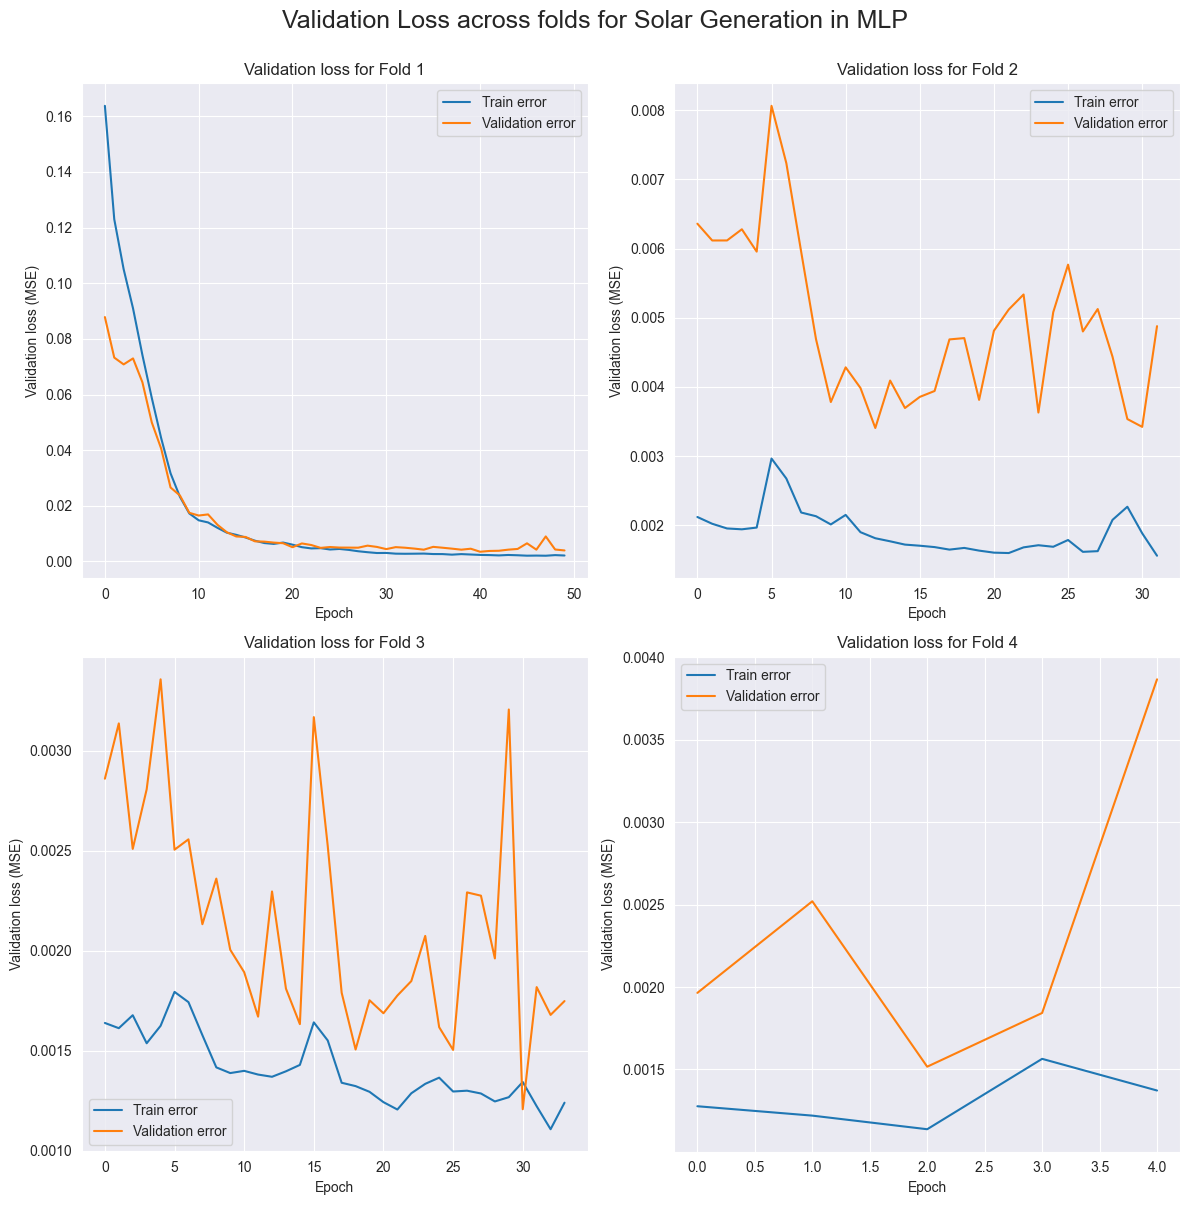

In [31]:
plt.figure(figsize=(12, 12))

for i, column in enumerate(loss_2):
    plt.subplot(2, 2, i+1)
    plt.plot(column, label="Train error")
    plt.plot(val_loss_2[i], label="Validation error")
    plt.xlabel('Epoch')
    plt.ylabel('Validation loss (MSE)')
    plt.legend()
    plt.title(f'Validation loss for Fold {i+1}')

plt.suptitle('Validation Loss across folds for Solar Generation in MLP', fontsize=18, y=1)
plt.tight_layout()
plt.show()

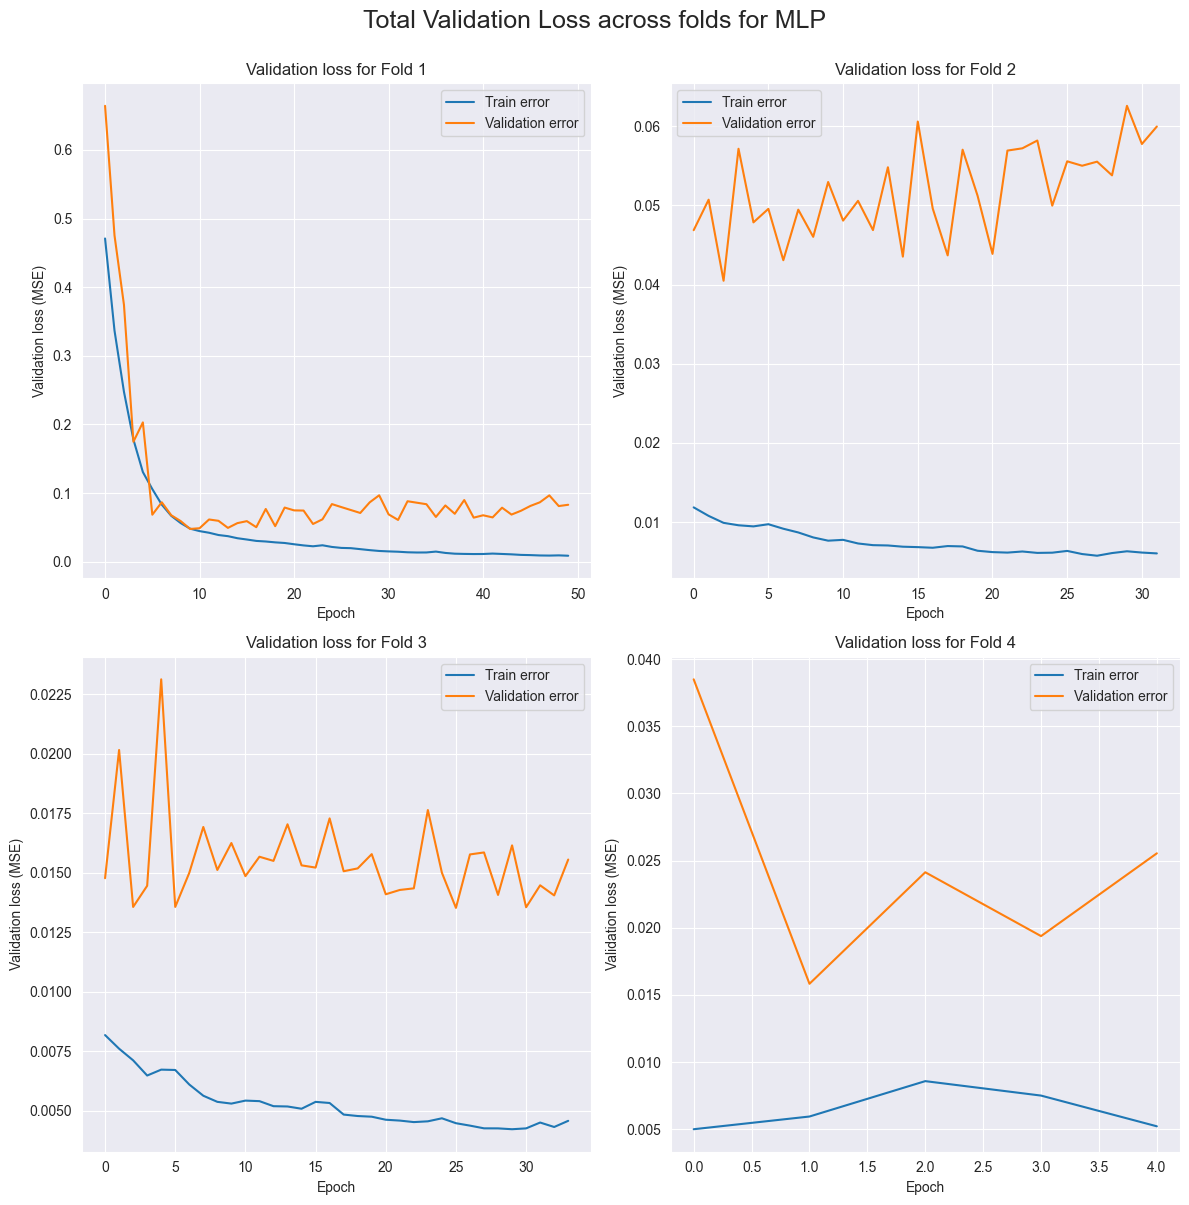

In [32]:
plt.figure(figsize=(12, 12))

for i, column in enumerate(loss):
    plt.subplot(2, 2, i+1)
    plt.plot(column, label="Train error")
    plt.plot(val_loss[i], label="Validation error")
    plt.xlabel('Epoch')
    plt.ylabel('Validation loss (MSE)')
    plt.legend()
    plt.title(f'Validation loss for Fold {i+1}')

plt.suptitle('Total Validation Loss across folds for MLP', fontsize=18, y=1)
plt.tight_layout()
plt.show()

In [33]:
headers = []
loss_df = []

for i, column in enumerate(loss):
    loss_df.append(column)
    loss_df.append(val_loss[i])
    headers.append(f"Fold {i} Train")
    headers.append(f"Fold {i} Val")
    

loss_df = pd.DataFrame(loss_df).T
loss_df.to_csv('../data/results/loss_lstm.csv', index=False, header=headers)

In [34]:
# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)

1/1 [==============================] - 0s 40ms/step


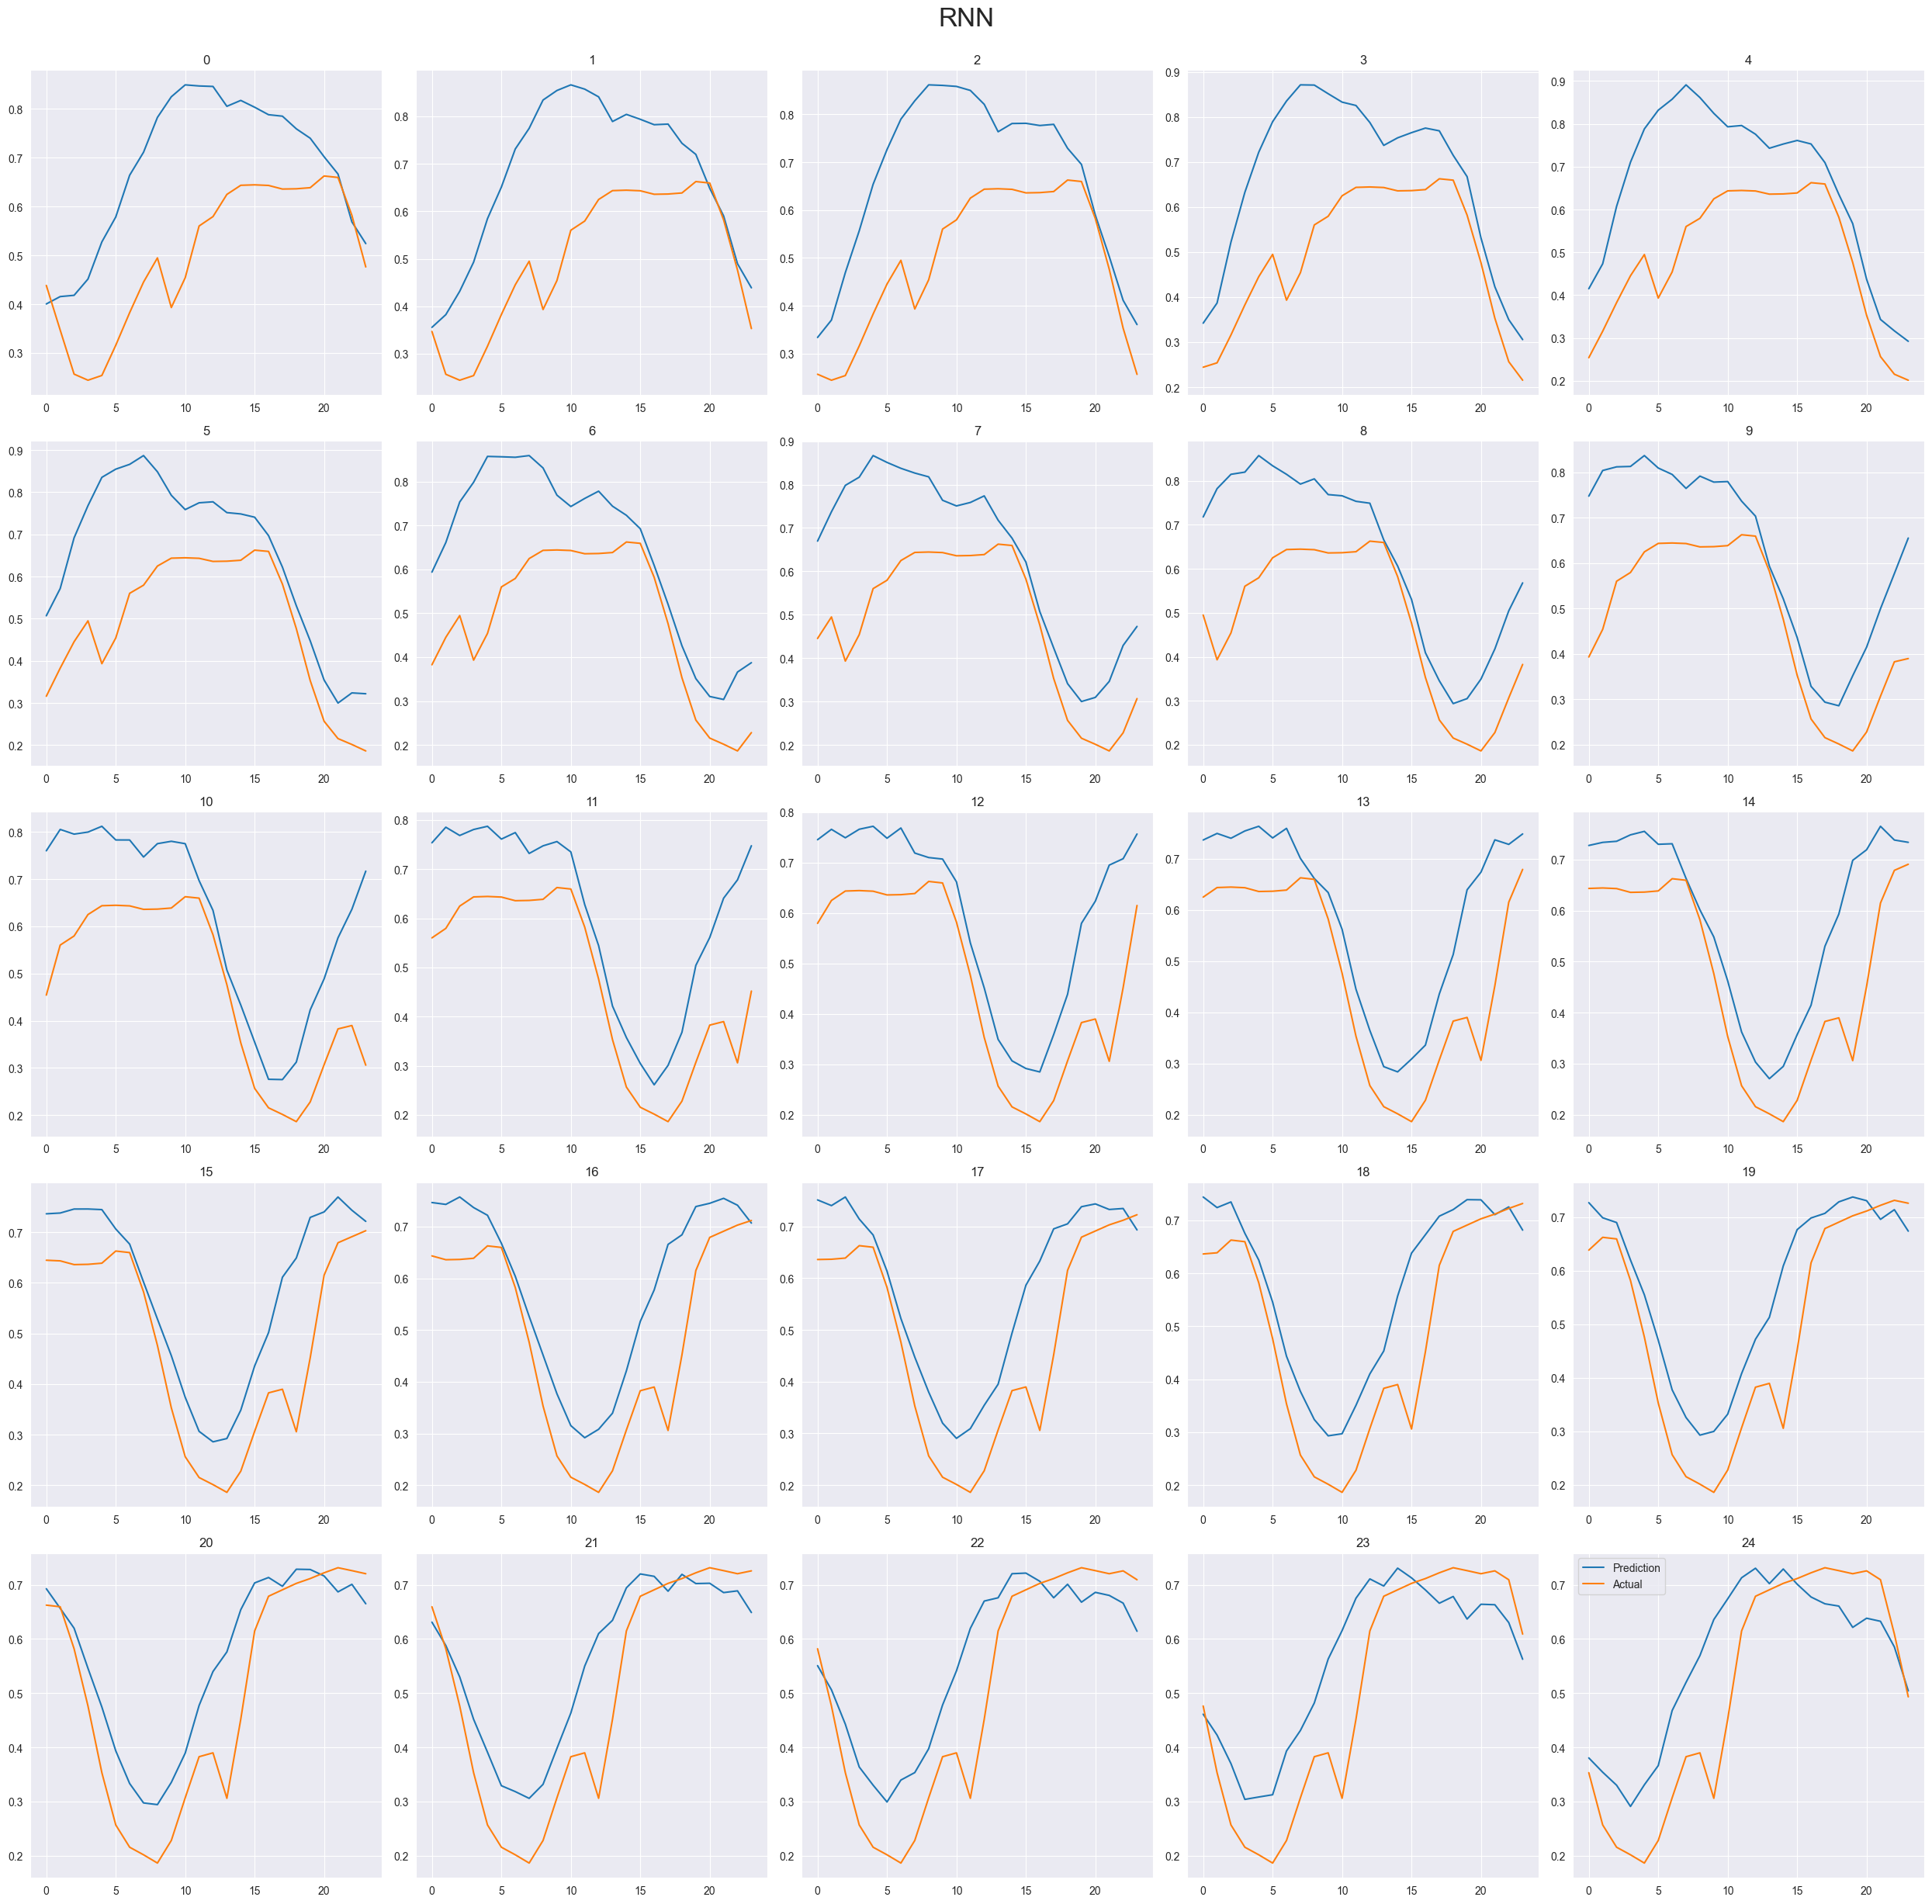

In [35]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_1):
    ax = axs[i]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_val[i, :, 0], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

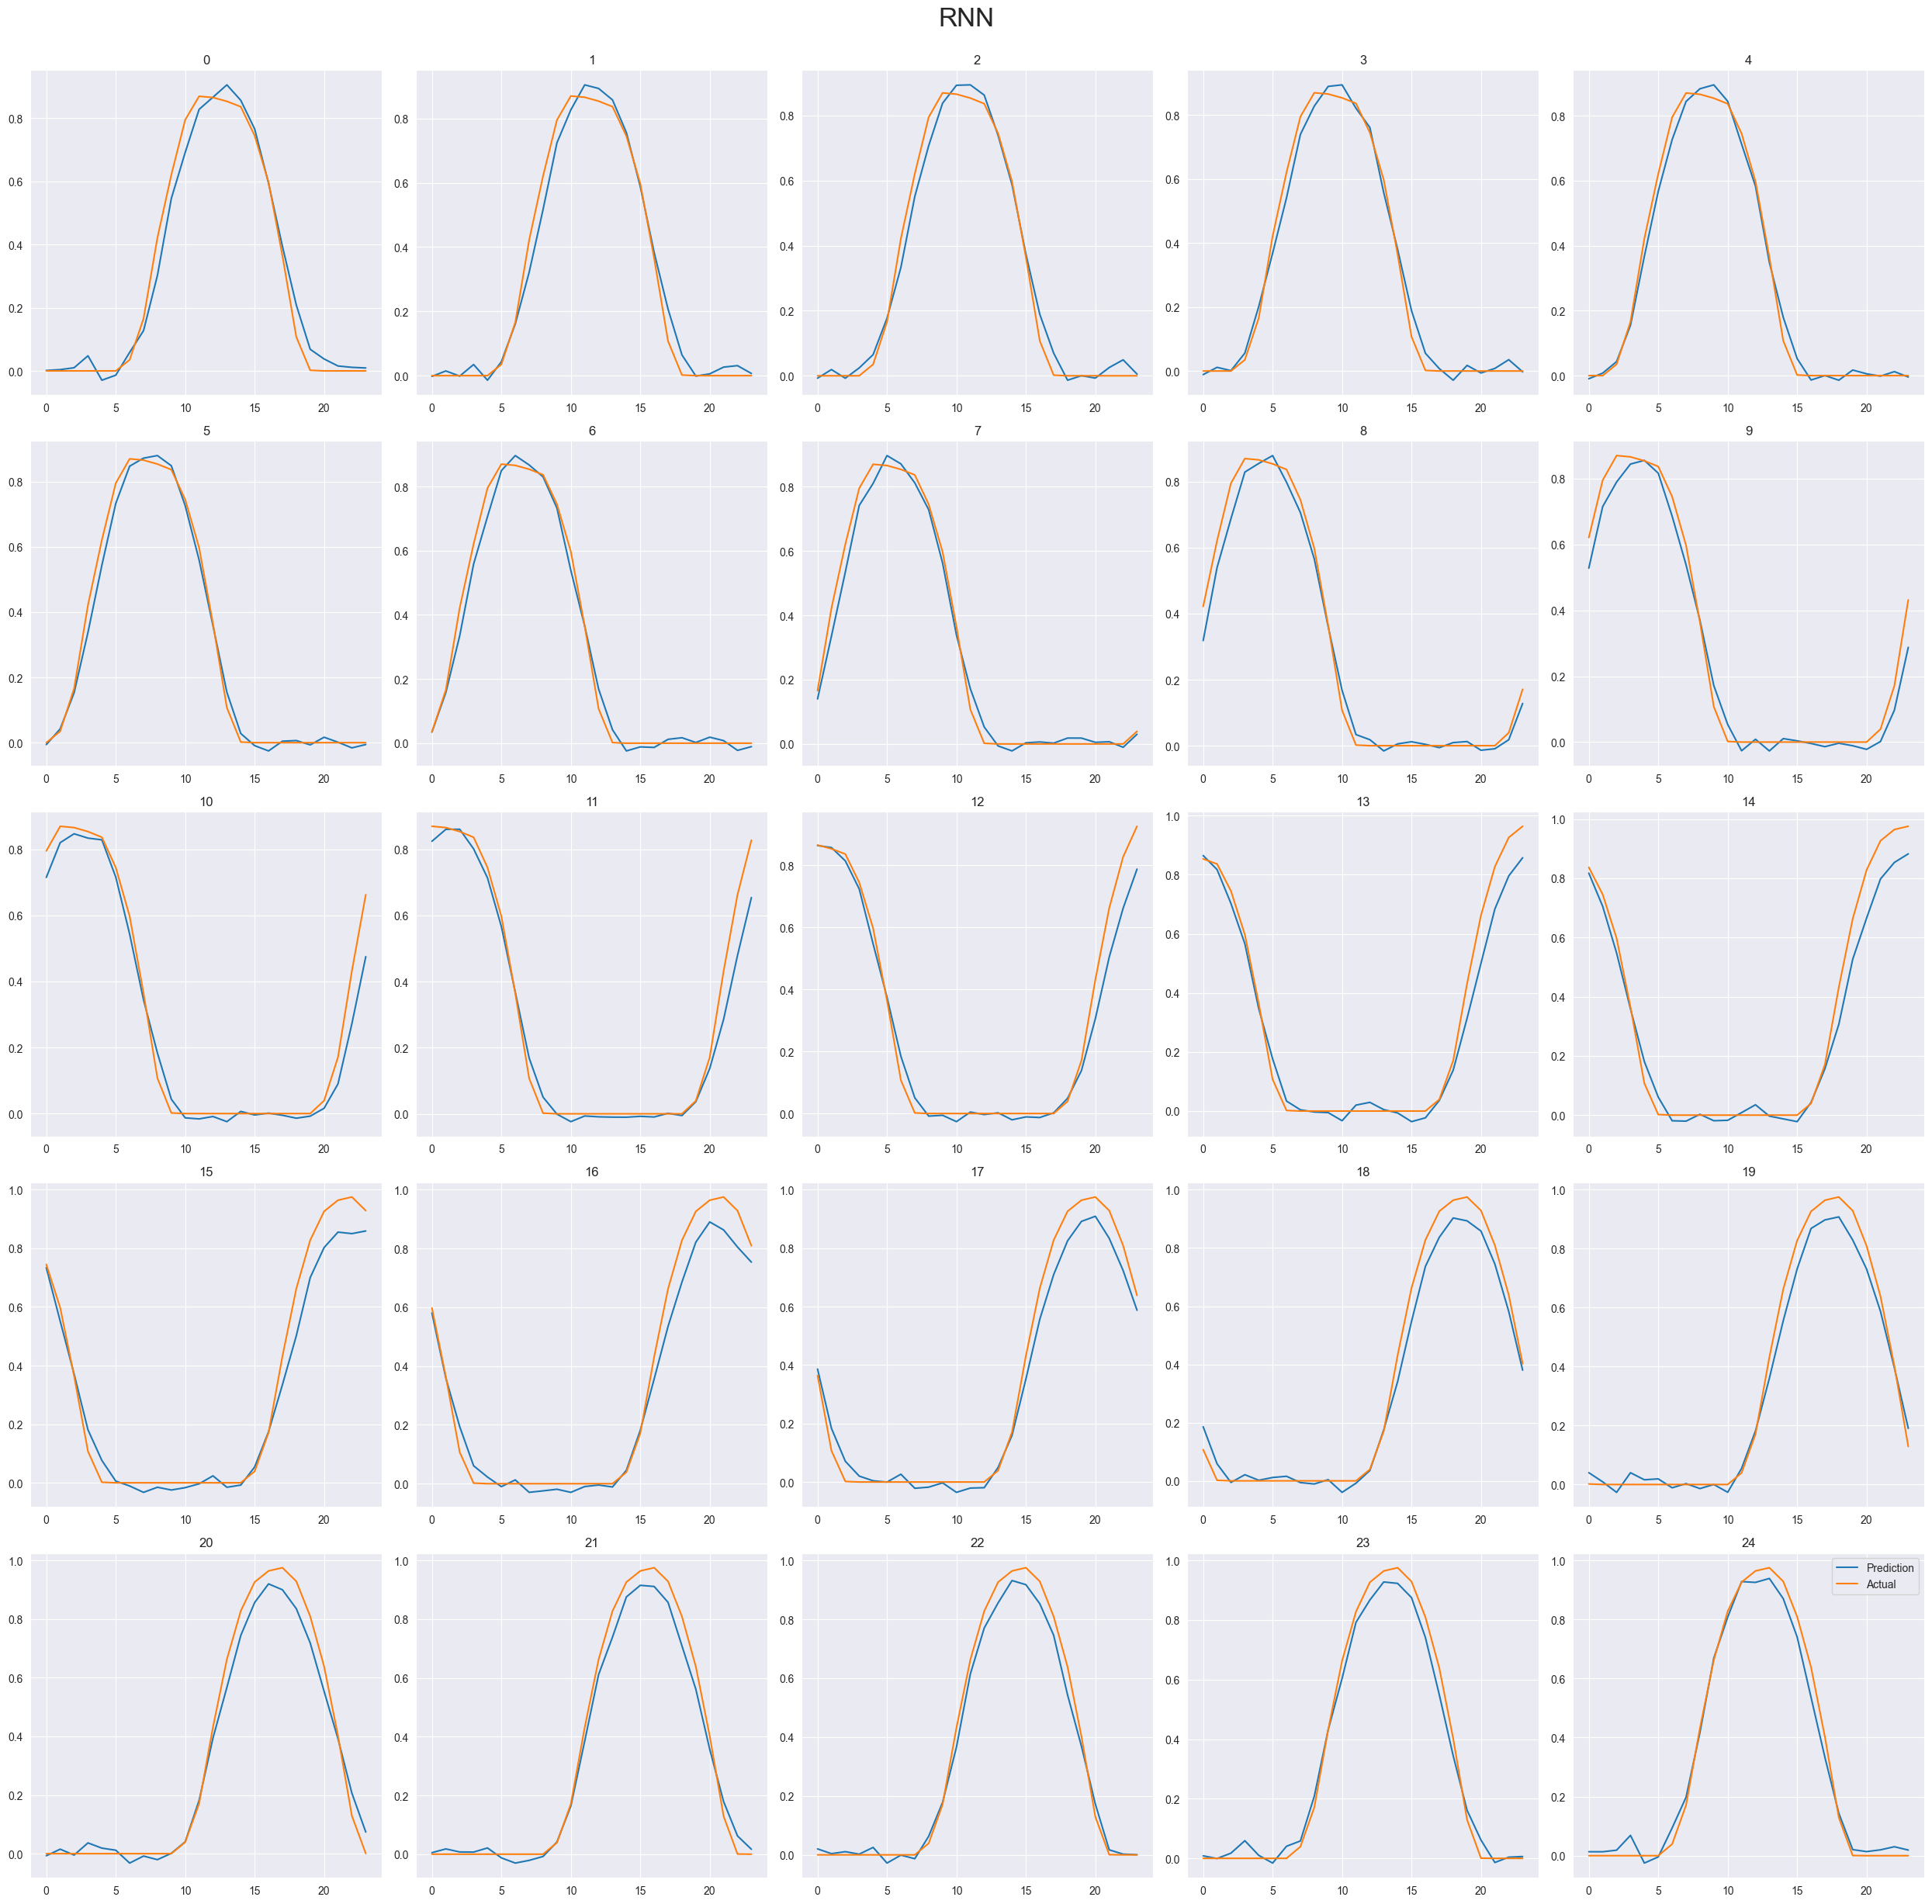

In [36]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_2):
    ax = axs[i]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_val[i, :, 1], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [37]:
rmse = 0
for i in range(len(predictions_1)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE for {columns_to_predict[0]} = {rmse}")

rmse = 0
for i in range(len(predictions_2)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE for {columns_to_predict[1]} = {rmse}")

RMSE for kg_CO2/kWh = 0.15778479074555268
RMSE for Avg solar generation = 0.050498649544125626


In [38]:
# Evaluate the model on the test data
predictions_1_test = []
predictions_2_test = []
#print(len(eval_target_variables))

total_time = 0

for i in range(len(Y_test)):
    current_batch = X_test[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    start = time.time()
    curr_pred1, curr_pred2 = model.predict(current_batch)
    end = time.time()
    total_time += end-start
    predictions_1_test.append(curr_pred1)
    predictions_2_test.append(curr_pred2)
    
print(f"Average prediction time is {total_time/len(Y_test)} seconds")

1/1 [==============================] - 0s 52ms/step
Average prediction time is 0.11131382942199707 seconds


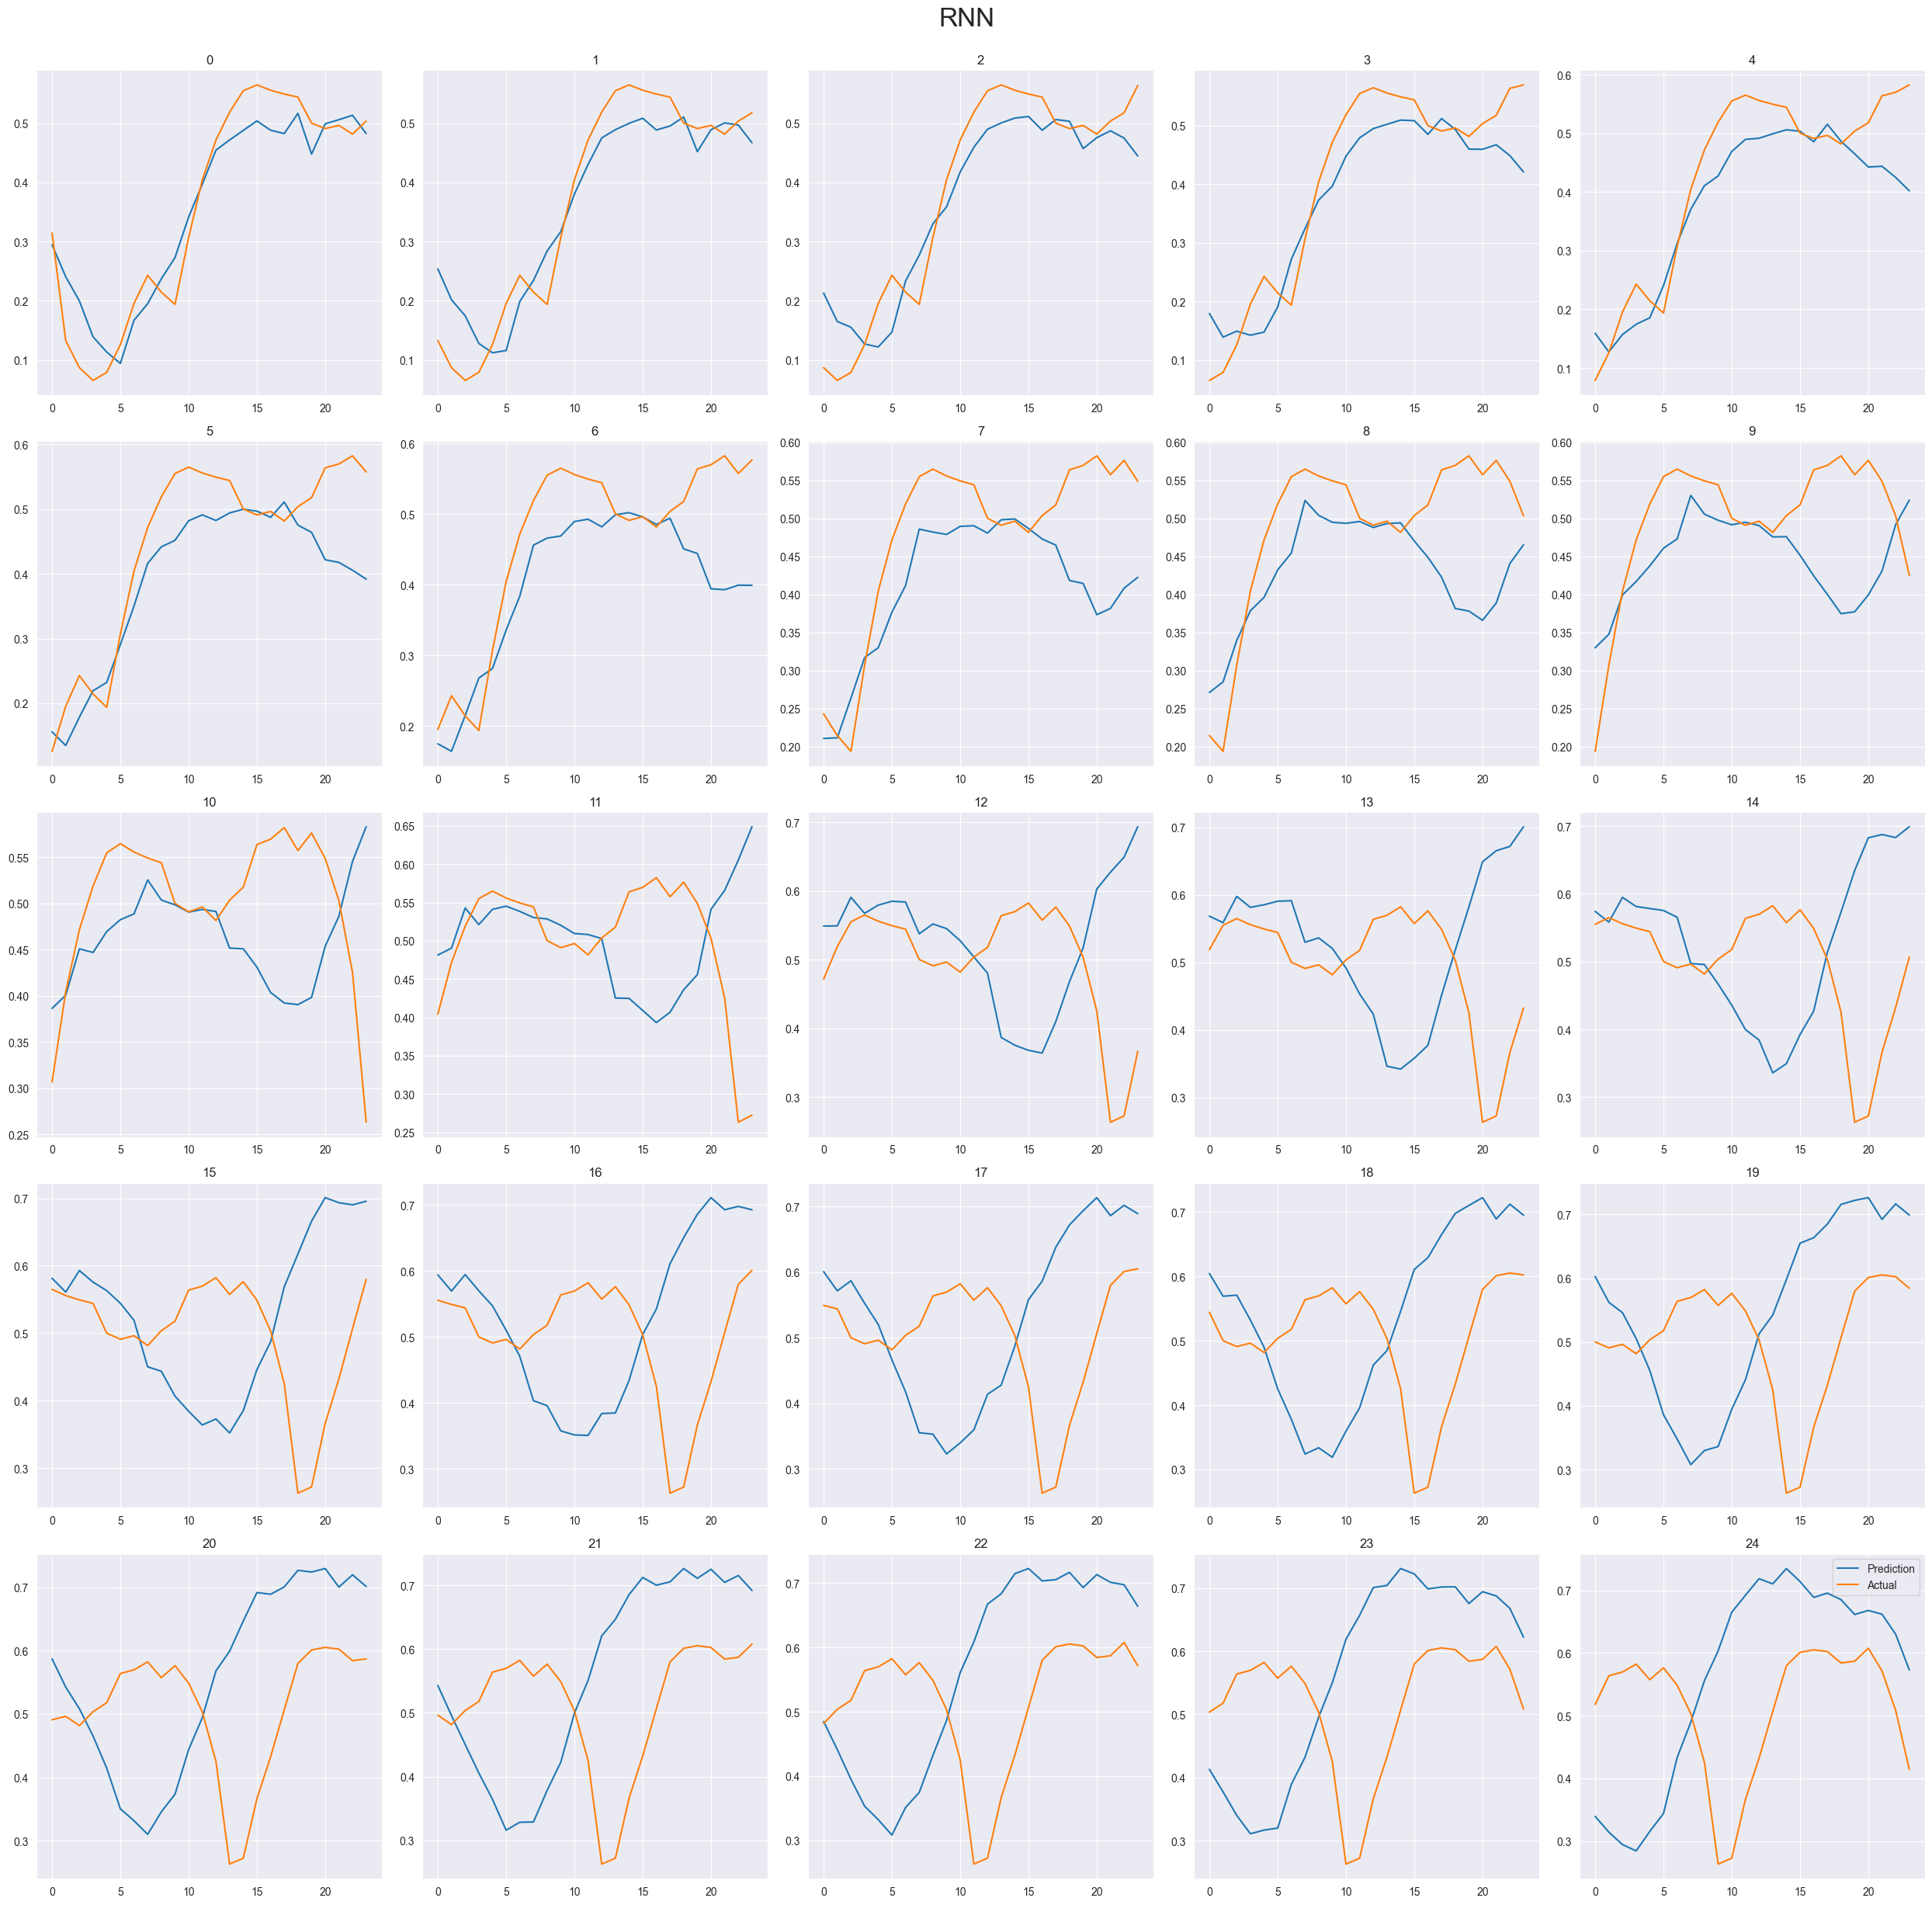

In [39]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_1_test):
    ax = axs[i]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_test[i, :, 0], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

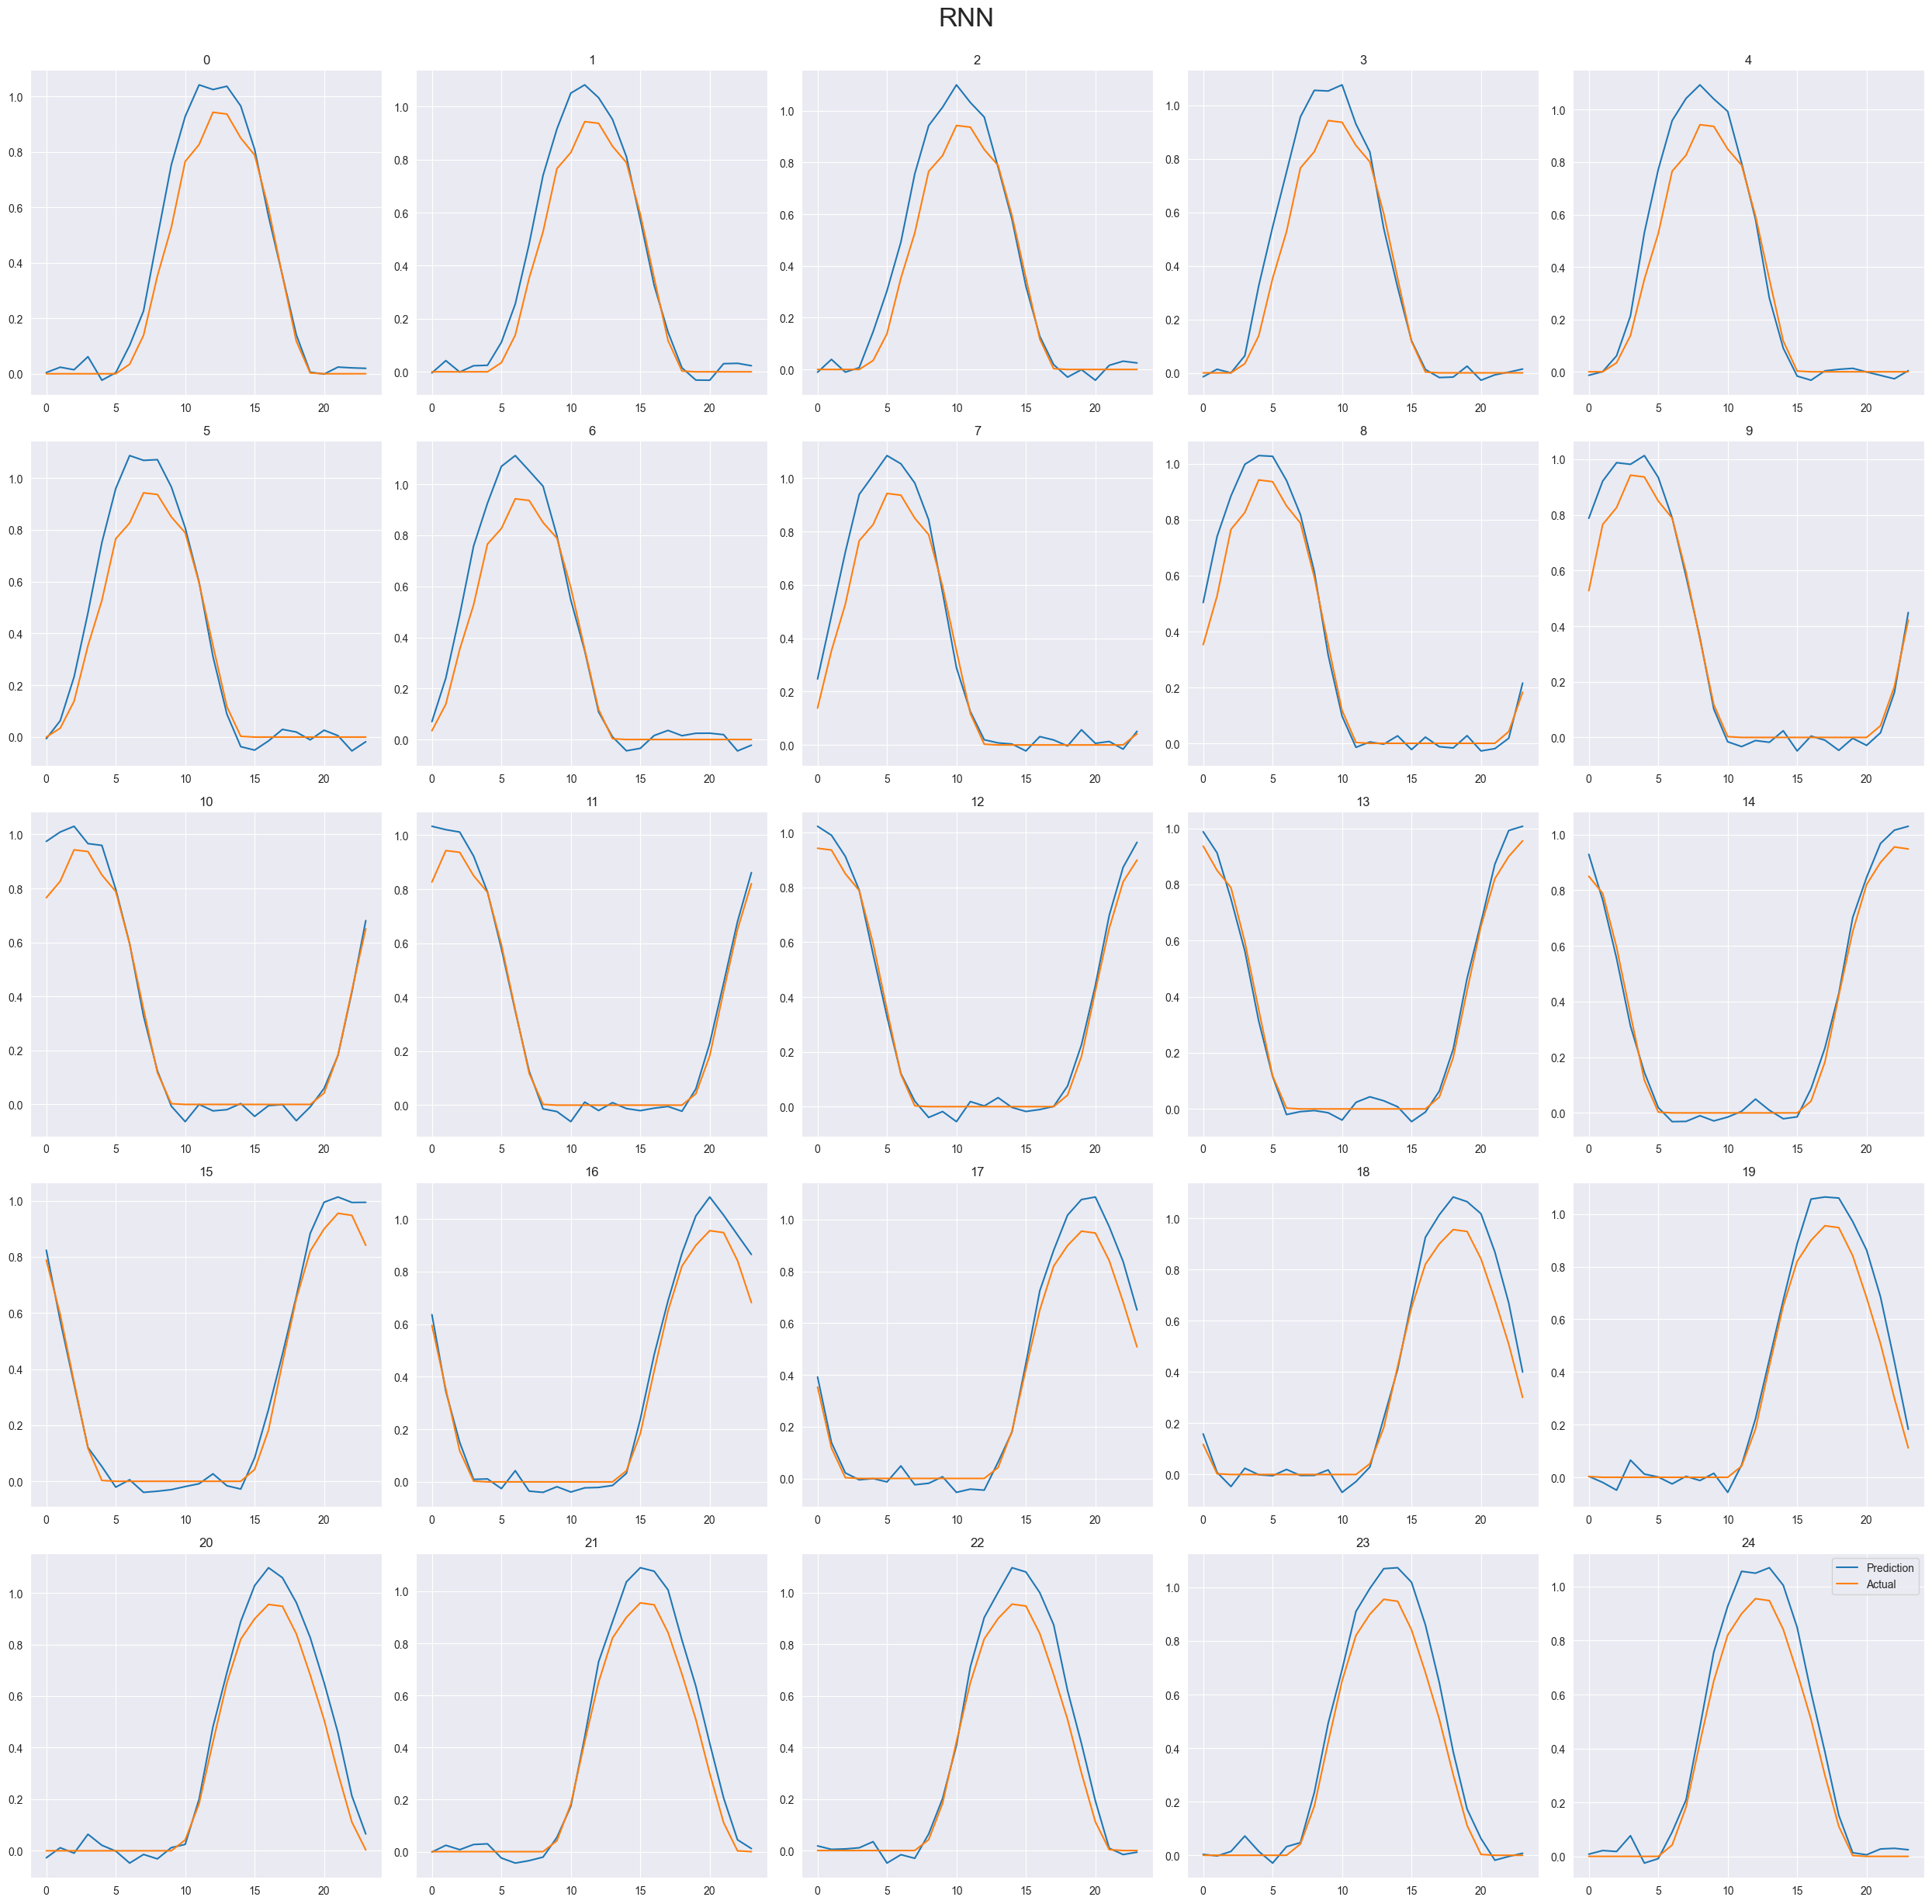

In [40]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_2_test):
    ax = axs[i]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_test[i, :, 1], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [41]:
rmse = 0
for i in range(len(predictions_1_test)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1_test[i][0], Y_test[i, :, 0]))

rmse /= len(predictions_1_test)    
print(f"RMSE for {columns_to_predict[0]} = {rmse}")

rmse = 0
for i in range(len(predictions_2_test)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2_test[i][0], Y_test[i, :, 1]))

rmse /= len(predictions_2_test)    
print(f"RMSE for {columns_to_predict[1]} = {rmse}")

RMSE for kg_CO2/kWh = 0.13750832351161693
RMSE for Avg solar generation = 0.0775080596952455


In [42]:
a = []
for column in predictions_1_test:
    a.append(column[0])
    
b = []
for column in predictions_2_test:
    b.append(column[0])

predictions1 = pd.DataFrame(a).T
predictions1.to_csv('../data/results_copies/carbon_lstm.csv', index=False, header=False)
predictions2 = pd.DataFrame(b).T
predictions2.to_csv('../data/results_copies/solar_lstm.csv', index=False, header=False)
